In [1]:
import django_setup
from IPython.display import Markdown, display
import pymupdf
import re

In [2]:
#%pip install nltk

In [3]:
def clean_text(text, _normalizes=None):
    txt = text
    try:
        normalizes = _normalizes or (
            ('\n ?\d+ ?/ ?\d+ ?\n', '\n'),
            ('[ ]{2,}', ' '),
            (' \\n', '\n'),
            #('([^\.]|\S)\n(\S)', r'\1 \2'),
            ('(\w)\n(.)', r'\1 \2'),
            ('(,)\n(.)', r'\1 \2'),
            #('()\n()', r'\1 \2'),
            ('\n\n', '\n'),
            ('-\n', '-'),
            ('^\n', ''),
            ('–', '-'),
            ('•', '*'),
            ('[“”]', '"'),
            #('', ''),
            #('', ''),
            #('', ''),
            #('', ''),
            #('', ''),
        )

        for regex, new in normalizes:
            search = re.search(regex, text)
            while search:
                text = re.sub(regex, new, text)
                search = re.search(regex, text)
        return text
    except:
        return txt


##### Seleciona uma Matéria Legislativa e faz limpeza inicial com clean_txext

In [6]:
from sapl.materia.models import MateriaLegislativa
lines = []
for m in MateriaLegislativa.objects.filter(tipo_id=27).order_by('-id')[:1]:
    doc = pymupdf.open(m.texto_original.path)
    text = ' '.join([page.get_text() for page in doc])
    text = clean_text(text)
    #text = text.replace('\n', ' ') # instrução transforma o texto em uma linha só.
    text = text.split('\n')
    text = list(filter(lambda x: x, text))
    lines.extend(text)
    # print(f'{m.id} - {m.ementa} - {m.texto_original.url}')

##### usa seleção de nltk para remover stopwords

In [7]:
import string
import nltk
#nltk.download("stopwords")
#nltk.download("punkt")
#nltk.download("punkt_tab")
stopwords = nltk.corpus.stopwords.words("portuguese")
pontuacao = string.punctuation

In [8]:
corpus = []
for line in lines:
    tokens = nltk.word_tokenize(line.lower(), language="portuguese")
    tokens = [t.lower() for t in tokens if t not in stopwords and t not in pontuacao]
    corpus.append(' '.join(tokens))

In [9]:
#%pip install -U spacy[cuda113]
#python -m spacy download pt_core_news_lg

# Lemming
import spacy

spacy.prefer_gpu()
nlp = spacy.load("pt_core_news_lg")

#Stemming
import nltk
#nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

In [ ]:
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stemmize(text):
    return ' '.join([stemmer.stem(token) for token in text.split()])

corpus_lemmatized = [lemmatize(text) for text in corpus]

corpus_stemmed = [stemmize(text) for text in corpus_lemmatized]


In [15]:
doc = nlp('\n'.join(lines))

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])


Noun phrases: ['EMENDA IMPOSITIVA, de 29 de Novembro de 2024.\n', 'Projeto', 'Lei Ordinária', 'Executivo', 'nº', 'Setembro', 'que', 'a Despesa', 'Município', 'Jataí', ', Estado', 'Goiás', ', para o Exercício', '"\nAutoria', 'Vereadora Alessandra Oliveira', 'recursos orçamentários', 'o(a', 'SECRETARIA MUNICIPAL DE MEIO AMBIENTE, para a recepção do valor de R$ 110.000,00 (cento e dez mil reais), que será destinado a Custear um veículo leve', 'Modelo Fiorino para o Centro de Castração, com a finalidade de transportar animais para tal fim.\n', 'A subscritora', 'Emenda Impositiva', 'a seguinte modificação', 'Projeto', 'Lei Orçamentária', ':\nArt 1º -', 'Unidade Orçamentária SECRETARIA MUNICIPAL DE MEIO AMBIENTE', '/ Código', 'E CONSERVAÇÃO', 'ATERRO', 'SANITÁRIO /', 'Natureza', 'Despesa', ', o valor', 'Art 2º - O valor deduzido de R$ 110.000,00 (cento e dez mil reais), será inserido na Unidade Orçamentária SECRETARIA MUNICIPAL DE MEIO AMBIENTE / Código:\n18.542.1839.1.344 - AQUISIÇÃO DE VEÍ

In [13]:
lines

['EMENDA IMPOSITIVA, de 29 de Novembro de 2024.',
 'Ao Projeto de Lei Ordinária do Executivo nº 84, de 30 de Setembro de 2024, que "Estima a Receita e fixa a Despesa do Município de Jataí, Estado de Goiás, para o Exercício de 2025."',
 'Autoria: Vereadora Alessandra Oliveira Altera destinação de recursos orçamentários, indicando o(a) SECRETARIA MUNICIPAL DE MEIO AMBIENTE, para a recepção do valor de R$ 110.000,00 (cento e dez mil reais), que será destinado a Custear um veículo leve Modelo Fiorino para o Centro de Castração, com a finalidade de transportar animais para tal fim.',
 'A subscritora da presente Emenda Impositiva, propõem a seguinte modificação no Projeto de Lei Orçamentária Anual supracitado:',
 'Art 1º - Deduz-se da Unidade Orçamentária SECRETARIA MUNICIPAL DE MEIO AMBIENTE / Código: 18.541.1839.2.113 - OPERAÇÃO E CONSERVAÇÃO DO ATERRO SANITÁRIO / Natureza da Despesa: 3.3.90.39.00, o valor de R$ 110.000,00 (cento e dez mil reais).',
 'Art 2º - O valor deduzido de R$ 110.00

In [8]:
jdict = {
    'lines': lines,
    'corpus': corpus,
    'corpus_lemmatized': corpus_lemmatized,
    'corpus_stemmed': corpus_stemmed,
}
import json
with open('data/001_corpus.json', 'w') as f:
    f.write(json.dumps(jdict))

In [5]:
import json
with open('data/001_corpus.json', 'r') as f:
    jdict = json.loads(f.read())
lines = jdict['lines']
corpus = jdict['corpus']
corpus_lemmatized = jdict['corpus_lemmatized']
corpus_stemmed = jdict['corpus_stemmed']

In [5]:
max_sentences = 0
for text in lines:
    sentences = len(text.split(' '))
    if sentences > max_sentences:
        max_sentences = sentences
print(max_sentences)

108


In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
corpus_embeddings = model.encode(corpus)

In [7]:
corpus_embeddings.shape

(142, 512)

In [8]:
import pandas as pd
df_corpus = pd.DataFrame(corpus_embeddings)
df_corpus.shape

(142, 512)

In [9]:
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca2 = PCA(n_components=2)
pca2_corpus_embeddings = pca2.fit_transform(corpus_embeddings)
pca3 = PCA(n_components=3)
pca3_corpus_embeddings = pca3.fit_transform(corpus_embeddings)

k_rng = range(2, 20)
wss_2D = []
for k in k_rng:
    num_clusters = k
    clustering_model_2D = KMeans(n_clusters=num_clusters)
    clustering_model_2D.fit(pca2_corpus_embeddings)
    clustering_assignments_2D = clustering_model_2D.labels_
    wss_2D_inertia = clustering_model_2D.inertia_
    wss_2D.append(wss_2D_inertia)
    #display(wss_2D_inertia)

wss_3D = []
for k in k_rng:
    num_clusters = k
    clustering_model_3D = KMeans(n_clusters=num_clusters)
    clustering_model_3D.fit(pca3_corpus_embeddings)
    clustering_assignments_3D = clustering_model_3D.labels_
    wss_3D_inertia = clustering_model_3D.inertia_
    wss_3D.append(wss_3D_inertia)
    #display(wss_3D_inertia)


In [10]:
listaWss2D = pd.DataFrame({'Clusters 2D': k_rng, 'wss_2D': wss_2D})
listaWss3D = pd.DataFrame({'Clusters 3D': k_rng, 'wss_3D': wss_3D})


<Axes: xlabel='Clusters 2D', ylabel='wss_2D'>

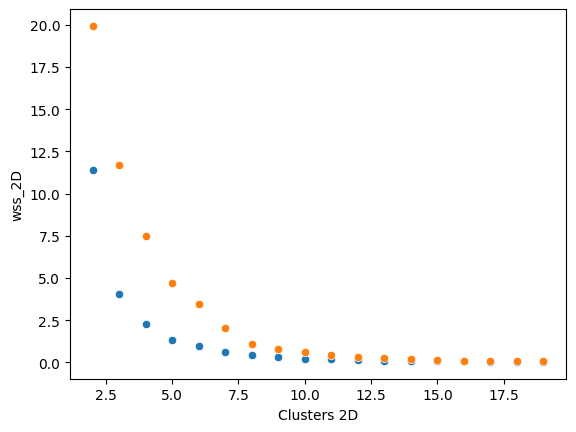

In [11]:
import seaborn as sns
sns.scatterplot(data=listaWss2D, x='Clusters 2D', y='wss_2D', markers='*')
sns.scatterplot(data=listaWss3D, x='Clusters 3D', y='wss_3D')

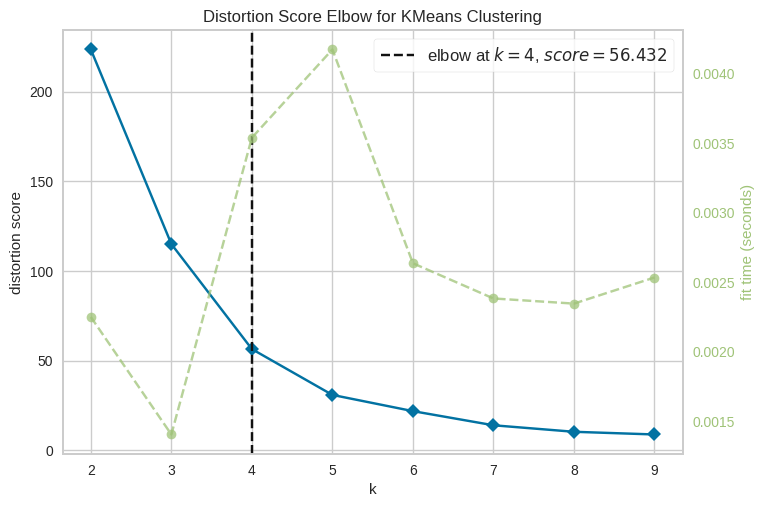

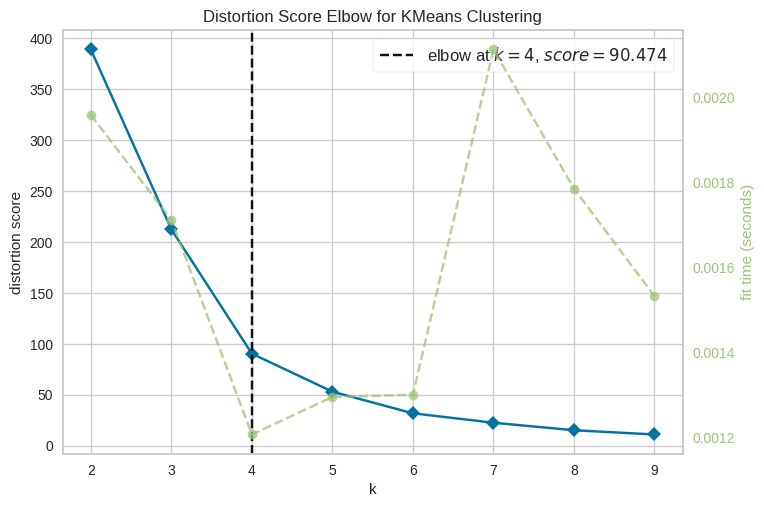

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=1), k=(2, 10))

In [12]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

X = listaWss2D
kelbow_visualizer(KMeans(random_state=1), X, k=(2,10))

X = listaWss3D
kelbow_visualizer(KMeans(random_state=1), X, k=(2,10))



In [13]:
k_2D=7
num_clusters_2D = k_2D
labels_2D = KMeans(n_clusters=num_clusters_2D, init='k-means++', random_state=200).fit(pca2_corpus_embeddings).labels_

k_3D=7
num_clusters_3D = k_3D
labels_3D = KMeans(n_clusters=num_clusters_3D, init='k-means++', random_state=200).fit(pca3_corpus_embeddings).labels_

In [14]:
import plotly.express as px
import plotly.graph_objects as go

indices = [i for i, c in enumerate(corpus_lemmatized)]

# Cria um gráfico de dispersão com os dados de embeddings PCA 2D
fig = px.scatter(
  pca2_corpus_embeddings,  # Dados de embeddings PCA 2D
  x=0,  # Coluna para o eixo x
  y=1,  # Coluna para o eixo y
  color=labels_2D,  # Coluna para a cor dos pontos
  size_max=20,  # Tamanho máximo dos pontos
  height=600,  # Altura do gráfico
  text=indices  # Texto a ser exibido em cada ponto
)

# Exibe o gráfico
fig.show()

fig = px.scatter_3d(
  pca3_corpus_embeddings, x=0, y=1, z=2, color=labels_3D,
  size_max=40,
  height=600,
  text=indices)

fig.show()


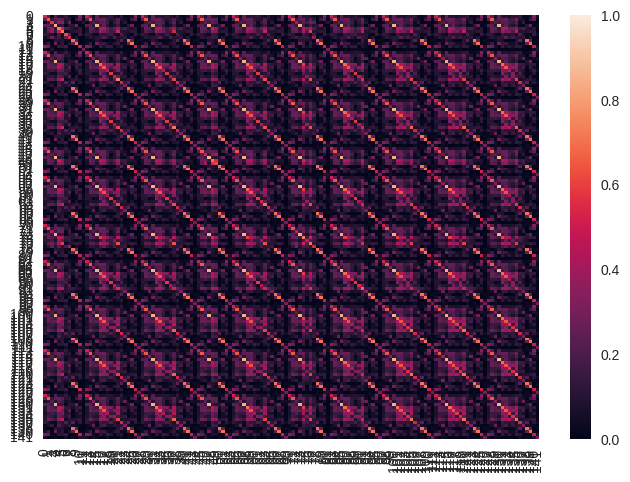

In [19]:
import numpy as np
corrs = np.inner(corpus_embeddings, corpus_embeddings)

g = sns.heatmap(
    corrs,
    vmin=0,
    vmax=1,
    xticklabels=indices,
    yticklabels=indices,
  )